In [1]:
# 1.Load Python Libraries
import numpy as np
import pandas as pd
from pandas import DataFrame
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.preprocessing import scale
from statsmodels.multivariate.pca import PCA
from statsmodels.stats.outliers_influence import variance_inflation_factor

C:\Users\chong\Anaconda3\envs\tensorflow\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
# 2.Load RECS Dataset
recs = pd.read_csv("GTECH 702 Final.csv")
#recs

In [3]:
# 3.Define Global Variables
div = recs.DIVISION.unique() # Division Index

dep_EL = ["Y1_BTUEL"] # Dependent Variable for Electricity
ind_EL = ["HDD65", "CDD65", "TOTSQFT", "DOLLAREL", "HDD50", "CDD80", "WSF", "OA_LAT"] # Independent Variables for Electricity
dep_NG = ["Y2_BTUNG"] # Dependent Variable for Natural Gas
ind_NG = ["HDD65", "CDD65", "TOTSQFT", "DOLLARNG", "HDD50", "CDD80", "WSF", "OA_LAT"] # Independent Variables for Natural Gas

energy = {"EL":[dep_EL, ind_EL], "NG": [dep_NG, ind_NG]}

vif_cutoff = 5
pvalue_cutoff = 0.05

In [4]:
# 4.Variable Constructor
def Var_Builder(df, dep_y, ind_x):
    y = df[dep_y]
    X = df[ind_x]
    return(y, X)
test_data = Var_Builder(recs, dep_EL, ind_EL)

In [5]:
# 5.Principle Component Analysis

# 5A.Conduct Principle Component Analysis
def PCA_Analysis(X):
    var_num = X.shape[1] # Count number of variables involved in PCA
    
    # Initialize PCA
    pca = PCA(X, ncomp=var_num)
    
    # 5A.Compute Eigenvalue Matrix
    eigen_Mat = DataFrame(0, columns=["Eigenvalue", "Variance"], index=np.arange(var_num))
    eigen_Mat["Variance"] = pca.eigenvals / sum(pca.eigenvals)
    eigen_Mat["Eigenvalue"] = pca.eigenvals / sum(pca.eigenvals) * var_num
    
    # 5B.Compute Component Matrix
    ldings = pca.loadings
    comp_Mat = ldings[ldings.columns[0:2]] # Use 2 principle components
    comp_Mat.columns = ["Component_1", "Component_2"]
    return(eigen_Mat, comp_Mat)
pca_out = PCA_Analysis(test_data[1])
#pca_out

# 5B.PCA Result Visualization: Scree Plot & Loading Plot
def PCA_Visualization(eigen_Mat, comp_Mat):
    # Scree Plot
    ax = plt.subplot()
    ax.plot(eigen_Mat.index, eigen_Mat["Eigenvalue"], "--o", linewidth=0.5)
    for i in eigen_Mat.index:
        ax.annotate(round(eigen_Mat.loc[i, "Eigenvalue"], 3), [i, eigen_Mat.loc[i, "Eigenvalue"]], fontsize=9)
    plt.xlabel("Component Index")
    plt.ylabel("Eigenvalue")
    plt.title("Scree Plot")
    plt.show()
    
    # Loading Plot
    fig, ax = plt.subplots()
    ax.scatter(comp_Mat["Component_1"], comp_Mat["Component_2"], color="orange")
    for i in comp_Mat.index:
        ax.annotate(i, [comp_Mat.loc[i, "Component_1"], comp_Mat.loc[i, "Component_2"]], fontsize=9)
    ax.plot([-1.1, 1.1], [0, 0], "k-", linewidth=0.5)
    ax.plot([0, 0], [-1.1, 1.1], "k-", linewidth=0.5)
    plt.xlim(-1, 1)
    plt.ylim(-1, 1)
    plt.xlabel("Component_1")
    plt.ylabel("Component_2")
    plt.title("Loading Plot")
    #fig.savefig("Loading Plot NG2.png", dpi=300)
    plt.show()
#PCA_Visualization(pca_out[0], pca_out[1])

In [6]:
# 6.Multiple Linear Regression Optimization

# 6A.Calibrate MLR Model: Return R-square, P-values, VIF Tables
def MLR(dep, ind):
    # Fit a MLR Model
    y = dep
    X = sm.add_constant(ind)
    model = sm.OLS(y, X).fit()
    # Produce R-square
    r2 = model.rsquared
    # Produce P-value
    pvalue = model.pvalues
    # Produce Parameters
    params = model.params
    # Produce VIF
    vif = DataFrame(0, index = ind.columns, columns=["Tolerance", "VIF"])
    for var in vif.index:
        try:
            vif.loc[var, "VIF"] = variance_inflation_factor(scale(ind), np.where(vif.index == var)[0])
        except:
            vif.loc[var, "VIF"] = 1.0
    vif["Tolerance"] = 1 / vif["VIF"]
    return(r2, pvalue, vif, params)
#test_out = MLR(test_data[0], test_data[1])

# 6B.Model Optimization: Iterative Process to Remove Variables with VIF >= 5; Remove Variables with P-value >= 0.05
def MLR_Optimizer(df, original_dep, original_ind):
    # initialize original input dependent & independent variables
    y = original_dep
    X = original_ind
    # construct dataset dataset based on given variables
    dep, ind = Var_Builder(df, y, X)
    # calibrate first MLR model with all variables
    r2, pvalue, vif, params = MLR(dep, ind)
    
    # Collinearity Diagnostics: iterative process to remove variables with VIF >= 5
    while any(vif["VIF"] >= vif_cutoff):
        # drop variables whose VIF values are higher than cutoff
        vif = vif.drop(vif.index[vif["VIF"] == max(vif["VIF"])])
        # recalibrate MLR model
        X = vif.index
        dep, ind = Var_Builder(df, y, X)
        r2, pvalue, vif, params = MLR(dep, ind)
    # Insignificant Variable Diagnostics: iterative process to remove insignificant variables with p-value >= 0.05
    while any(pvalue[X] >= pvalue_cutoff):
        pvalue = pvalue[X]
        pvalue = pvalue.drop(pvalue.index[pvalue == max(pvalue)])
        X = pvalue.index
        dep, ind = Var_Builder(df, y, X)
        r2, pvalue, vif, params = MLR(dep, ind)
    return(r2, params)
#MLR_Optimizer(recs, dep_NG, ind_NG)

In [7]:
# 7.MLR Model Optimization for 10 Divisions in terms of two types of energy
def Div_iterator(dataset, division):
    # 7A.Construct Output Constant Table
    # Column Name
    col_names = ["R-Square", "const"] + list(set(ind_EL).union(ind_NG))
    # Row Name
    row_names = ["NWEL"] + [str(i)+"EL" for i in div] + ["NWNG"] + [str(i)+"NG" for i in div]
    # Table Construction
    const_tab = DataFrame(0, index=row_names, columns=col_names)
    
    # 7B.Iterate over Regions
    for engy in energy.keys():
        # Calibrate MLR with Nationwide dataset
        y, X = [energy[engy][0], energy[engy][1]]
        r2, coef = MLR_Optimizer(dataset, y, X)
        # insert R-square
        const_tab.loc["NW" + engy, "R-Square"] = r2
        # insert coefficients
        for var_name in coef.index:
            const_tab.loc["NW" + engy, var_name] = coef[var_name]
    
        # Calibrate MLR with Regional dataset
        for div_ix in division:
            try:
                sub_reg = dataset[dataset["DIVISION"] == div_ix]
                r2, coef = MLR_Optimizer(sub_reg, y, X)
                const_tab.loc[str(div_ix) + engy, "R-Square"] = r2
                for var_name in coef.index:
                    const_tab.loc[str(div_ix) + engy, var_name] = coef[var_name]
            except:
                pass
    return(const_tab)
coef_summary = Div_iterator(recs, div)
coef_summary

,R-Square,const,HDD50,CDD80,TOTSQFT,DOLLARNG,DOLLAREL,OA_LAT,HDD65,CDD65,WSF
NWEL,0.769135,3400.736924,1.111621,4.839418,2.224815,0.000000,20.686313,325.661746,0.000000,0.000000,-8300.101657
10EL,0.788792,-130.119936,2.615038,10.091225,2.054339,0.000000,14.657638,-240.427817,0.000000,0.000000,9842.164144
1EL,0.905137,-9975.126142,3.067484,0.000000,0.401518,0.000000,18.816340,-874.969195,0.000000,0.000000,7863.331124
3EL,0.934005,14531.376575,-1.422110,0.000000,0.000000,0.000000,31.561797,0.000000,0.000000,0.000000,-21417.719079
4EL,0.846832,-7241.687091,0.000000,32.880099,0.562644,0.000000,37.074738,795.308520,0.000000,0.000000,0.000000
2EL,0.862116,21495.832533,0.000000,0.000000,0.654024,0.000000,18.133913,-1564.266390,0.000000,0.000000,-26762.760407
8EL,0.952318,-17101.005372,1.428562,0.000000,0.000000,0.000000,35.260189,0.000000,1.530669,5.381956,0.000000
5EL,0.904491,20314.924382,0.000000,-19.565622,1.054606,0.000000,26.546834,0.000000,0.000000,0.000000,-38890.002340
9EL,0.935328,1831.821434,0.000000,-1.580934,0.000000,0.000000,28.118592,0.000000,0.000000,0.000000,0.000000
7EL,0.871934,6041.812964,9.841627,0.000000,1.334725,0.000000,23.497863,0.000000,0.000000,0.000000,-14277.059988


In [8]:
# 8.Calculate Predicted Energy Usage: Use Both Nationwide & Regional MLR Model to Predict Energy Consumption
def predict(d_recs, const_tab):
    # 8A.insert new columns to recs dataset
    new_nm = ["NWELpred", "NWNGpred", "REGELpred", "REGNGpred"]
    new_ix = d_recs.index
    new_df = DataFrame(0, index=new_ix, columns=new_nm)
    d_recs = pd.concat([d_recs, new_df], axis=1)
    # 8B.calculate predicted energy consumption
    for engy in energy.keys():
        # 8C.fill colunm "NWELpred" & "NWNGpred" with nationwide MLR model & coefficients
        # initialize "NWELpred" & "NWNGpred" with "const" values
        d_recs.loc[:, "NW" + engy + "pred"] = const_tab.loc["NW" + engy, "const"]
        # iterate over all independent variables to calculate linear combination
        for var in energy[engy][1]:
            d_recs.loc[:, "NW" + engy + "pred"] += d_recs.loc[:, var] * const_tab.loc["NW" + engy, var]
        
        # 8D.fill colunm "REGELpred" & "REGNGpred" with regional MLR model & coefficients
        # iterate & select sub-division
        for div_ix in div:
            # initialize "REGELpred" & "REGNGpred" with "const" values
            d_recs.loc[d_recs["DIVISION"] == div_ix, "REG" + engy + "pred"] = const_tab.loc[str(div_ix) + engy, "const"]
            # iterate over all independent variables to calculate linear combination
            for var in energy[engy][1]:
                d_recs.loc[d_recs["DIVISION"] == div_ix, "REG" + engy + "pred"] += d_recs.loc[d_recs["DIVISION"] == div_ix, var] * const_tab.loc[str(div_ix) + engy, var]
    return(d_recs)
pred_recs = predict(recs, coef_summary)
#pred_recs

In [9]:
# 9.Compare Prediction Between Observed and Predicted Energy Consumption Data Produced by Nationwide & Regional MLR Model
def Model_Validation(pred_data):
    # 9A.intialize output validation table
    val_tab_EL = DataFrame(0, index=div, columns=["DIVISION", "SAE_EL"])
    val_tab_EL.loc[:, "DIVISION"] = val_tab_EL.index
    val_tab_NG = DataFrame(0, index=div, columns=["DIVISION", "SAE_NG"])
    val_tab_NG.loc[:, "DIVISION"] = val_tab_NG.index
    # 9B.iterate over divisions and calculate "BIAS" & "SAE"
    for div_ix in div:
        sub_div = pred_data.loc[pred_data["DIVISION"] == div_ix, :]
        # calculate "SAE" between observed y-values & regional MLR predicted y-values
        val_tab_EL.loc[div_ix, "SAE_EL"] = sum(np.absolute(sub_div.loc[:, "Y1_BTUEL"] - sub_div.loc[:, "REGELpred"])) / len(sub_div.index)
        val_tab_NG.loc[div_ix, "SAE_NG"] = sum(np.absolute(sub_div.loc[:, "Y2_BTUNG"] - sub_div.loc[:, "REGNGpred"])) / len(sub_div.index)
    SAE_tab = pd.merge(val_tab_EL, val_tab_NG)
    return(SAE_tab)
val_tab = Model_Validation(pred_recs)
val_tab

,DIVISION,SAE_EL,SAE_NG
0,10,5094.522662,5785.292984
1,1,3278.760327,6239.137899
2,3,3216.823450,11511.241720
3,4,5360.500043,8996.937495
4,2,4159.500133,6180.095883
5,8,2069.056047,5232.175123
6,5,5734.593566,7674.161061
7,9,3966.234470,7616.174012
8,7,6236.238268,5071.327606
9,6,4687.531803,9310.989601


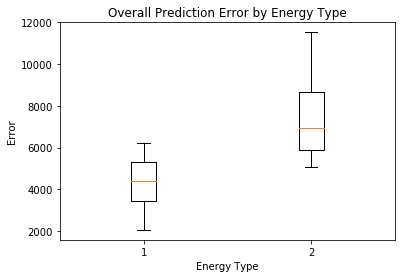

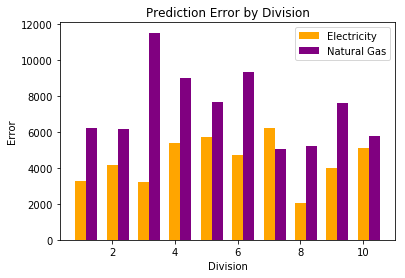

In [10]:
# 10.Visualize SAE by Division
def vis_sae(val_tab):
    # 10A.plot error of prediction by energy type
    fig, ax = plt.subplots()
    data = [val_tab["SAE_EL"], val_tab["SAE_NG"]]
    ax.boxplot(data)
    plt.xlabel("Energy Type")
    plt.ylabel("Error")
    plt.title("Overall Prediction Error by Energy Type")
    fig.savefig("recs_boxplot.png", dpi=300)
    plt.show()
    
    # 10B.plot error of prediction by division
    bar_width = 0.35
    fig, ax = plt.subplots()
    EL_bar = ax.bar(val_tab["DIVISION"], val_tab["SAE_EL"], bar_width, color="orange")
    NG_bar = ax.bar(val_tab["DIVISION"] + bar_width, val_tab["SAE_NG"], bar_width, color="purple")
    ax.legend((EL_bar[0], NG_bar[0]), ('Electricity', 'Natural Gas'))
    plt.xlabel("Division")
    plt.ylabel("Error")
    plt.title("Prediction Error by Division")
    fig.savefig("recs_barplot.png", dpi=300)
    plt.show()
vis_sae(val_tab)

In [11]:
# 11.export data
coef_summary.to_csv("coef_tab.csv")
val_tab.to_csv("pred_err_tab.csv", index = None)